## 01 Ridership Time Series Forecasting - Single Fold
This series of notebook builds a machine learning time series forecasting model to predict demand of the Boston Bluebikes bikeshare system. Unlike other machine learning problems, time series models must use validation data that occurs *after* the training data. This 01 notebook uses a simplified approach by taking a single fold of the data; the model is trained on the first 80% of the data and the last 20% is used for validation. Follow-on notebooks will look at more complicated approaches like sliding window or forward chaining.

### Notebook Objectives
1. Process zip files to extract all trip data from 2015 to present.
2. Pickle the processed trips dataframe for future operations.
3. Build a ML time series model from a single fold of the data by modeling signal drift, seasonality, and residual noise.

In [241]:
from pathlib import Path
from zipfile import ZipFile
import pandas as pd
from pandas.plotting import autocorrelation_plot
import logging
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn import base
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import Ridge, SGDRegressor

logging.basicConfig(filename='preprocess.log', filemode='w', 
        level=logging.DEBUG, force=True,
        format='%(asctime)s %(levelname)s:%(message)s')

In [36]:
# Extract trips data from https://s3.amazonaws.com/hubway-data/index.html
for path in Path('../data/').glob('*.zip'):
    with ZipFile(path, mode="r") as z:
        z.extractall(Path('../data/extracted/'))

In [37]:
# Generate dataframe with trips data
trips = pd.DataFrame()
for path in Path('../data/extracted/').glob('*.csv'):
    logging.info(f'Processing {path}')
    trips = pd.concat([trips, pd.read_csv(path)])

# Pickle results
trips.to_pickle(Path('../assets/trips_df.pkl'))

In [3]:
# Load pickled dataframe (2.6 GB! Lots of data here)
trips = pd.read_pickle(Path('../assets/trips_df.pkl'))

In [61]:
# Inspect data
print(f'Shape: {trips.shape}')

Shape: (16868559, 16)


Over 16 million observations here! That's a lot of bike trips from 2015 to 2023.

In [5]:
# Inspect columns and datatypes
trips.dtypes

tripduration                 int64
starttime                   object
stoptime                    object
start station id             int64
start station name          object
start station latitude     float64
start station longitude    float64
end station id              object
end station name            object
end station latitude        object
end station longitude       object
bikeid                       int64
usertype                    object
postal code                 object
birth year                  object
gender                     float64
dtype: object

In [7]:
# Convert to datetime
trips['starttime'] = pd.to_datetime(trips['starttime'], format='%Y-%m-%d')
trips['stoptime'] = pd.to_datetime(trips['stoptime'], format='%Y-%m-%d')

In [202]:
# Get daily trip counts
daily = trips.groupby(by=[trips['starttime'].dt.date], 
                             as_index=True).agg(count=('tripduration', 'count'))
daily.index = pd.Index(daily.index).rename('date')
daily.index = pd.to_datetime(daily.index, format='%Y-%m-%d')

# Pickle results
daily.to_pickle(Path('../assets/daily_df.pkl'))

In [203]:
# Load pickled dataframe
daily = pd.read_pickle(Path('../assets/daily_df.pkl'))

In [204]:
# Inspect number of observations after groupby operation
print(daily.shape)
daily.head()

(2947, 1)


,count
date,
2015-01-01,127
2015-01-02,213
2015-01-03,142
2015-01-04,112
2015-01-05,337


In [188]:
# Test-train split. This notebook uses a single fold (see other notebooks for other approaches)
train = daily[:int(len(daily)*0.8)].squeeze()
valid = daily[int(len(daily)*0.8):].squeeze()

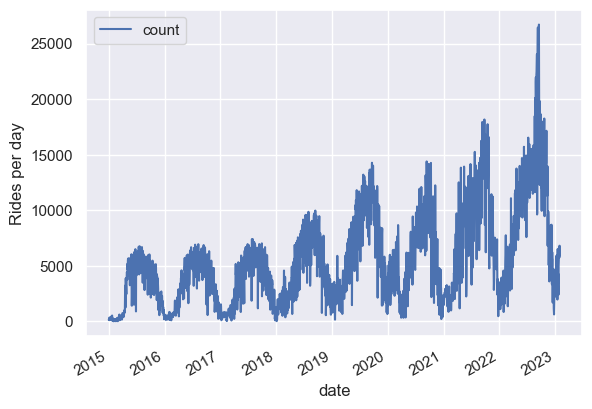

In [189]:
# Plot number of rides over the years
daily.plot()
plt.ylabel('Rides per day');

### Modeling Drift
From the plot of daily rides over time, it appears that the rate of growth isn't quite linear but perhaps more quadratic. Let's create a custom transformer that converts the time into days and generates $t$ and $t^2$ features.

Training score: 0.1720779812238704
Validation score: -0.42737693839074176


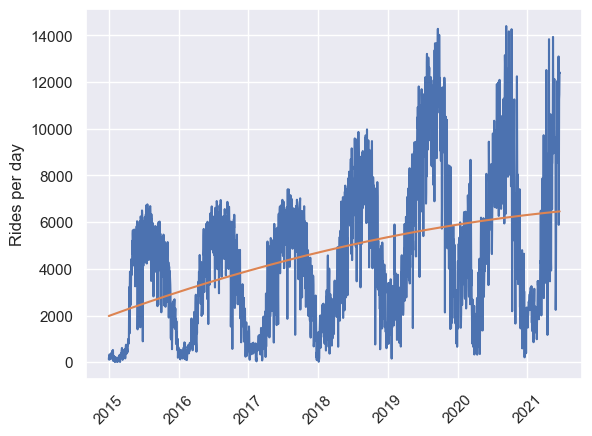

In [205]:
# TODO Does an index selector simplify things?
# class IndexSelector(base.BaseEstimator, base.TransformerMixin):
#     """Return indices of data frame or Series for use in other estimators."""
    
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X):
#         return X.index

class QuadBackground(base.BaseEstimator, base.TransformerMixin):
    """Convert datetime to days and generate t and t^2 features"""
    
    def fit(self, X, y=None):
        self.X0 = X[0]
        return self
    
    def transform(self, X):
        days = (X - self.X0).days
        return np.c_[days, days**2]

# drift = Pipeline([('indices', IndexSelector()),
#                   ('drift', QuadBackground()),
#                   ('regressor', Ridge())])
drift = Pipeline([('drift', QuadBackground()),
                  ('regressor', Ridge())])

drift.fit(train.index, train)

plt.plot(train.index, train.values,
         train.index, drift.predict(train.index))
plt.xticks(rotation=45);
plt.ylabel('Rides per day');

# Metrics
print(f'Training score: {drift.score(train.index, train)}')
print(f'Validation score: {drift.score(valid.index, valid)}')

### Modeling Seasonality
Let's find the frequencies of the seasonality in the signal using an FFT.

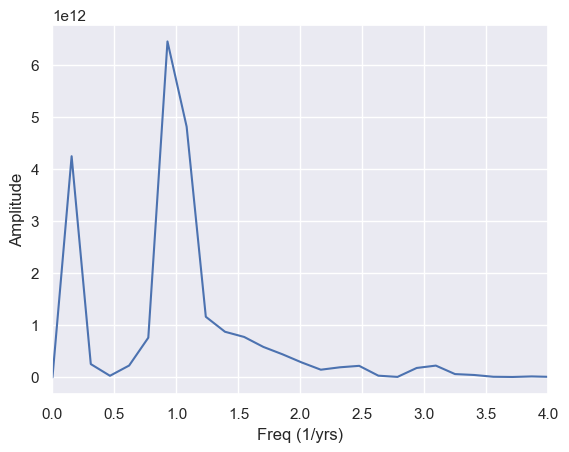

In [238]:
# Fourier transforms
fft_daily = np.fft.fft(train - train.mean())
yrs = (train.index[-1] - train.index[0]).days / 365.

plt.plot(np.arange(len(fft_daily)) / yrs, np.abs(fft_daily)**2)
plt.xlim(0, 4)
plt.xlabel('Freq (1/yrs)');
plt.ylabel('Amplitude');

There is a defined peak at 1/year denoting a yearly cycle. Since time is measured in days here, the corresponding period is 365 days. There is also a noteable 5 year cycle (0.2/year or period of 365*5 days). At first pass this cycle does not seem to have an obvious physical meaning in reality and instead is believed to be an artifact from the limited number of years in the dataset.

We can next model seasonality as sinusoidal with a single Fourier series term:

$$ f(t) = A \sin\frac{2\pi t}{P} + B\cos\frac{2\pi t}{P} + f_0 \ . $$

Where P is the period and the coefficients $A$, $B$, and $f_0$ are fit with linear regression.

Training score: 0.6899445854301884
Validation score: 0.36635733401792425


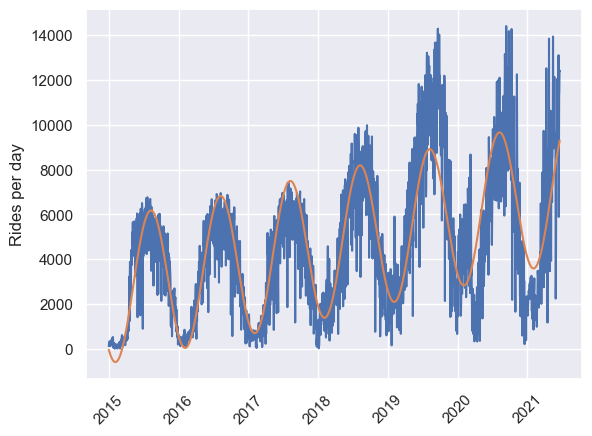

In [280]:
class FourierComponents(base.BaseEstimator, base.TransformerMixin):
    '''Return single Fourier term based on signal period'''

    def __init__(self, period):
        self.period = period
    
    def fit(self, X, y=None):
        self.X0 = X[0]
        return self
    
    def transform(self, X):
        dt = (X - self.X0).days * 2 * np.pi / self.period
        return np.c_[np.sin(dt), np.cos(dt)]

union = FeatureUnion([('drift', QuadBackground()),
                      ('fourier_1yr', FourierComponents(365))])

model_drift_fourier = Pipeline([('union', union),
                                ('regressor', Ridge())])

model_drift_fourier.fit(train.index, train)

# Visualize results
plt.plot(train.index, train, 
         train.index, model_drift_fourier.predict(train.index));
plt.xticks(rotation=45);
plt.ylabel('Rides per day');     

# Metrics check
print(f'Training score: {model_drift_fourier.score(train.index, train)}')
print(f'Validation score: {model_drift_fourier.score(valid.index, valid)}')

### Modeling Weekly Cycles
A Fourier term could also be used to model the weekly cycle, but in many cases a categorical feature works better to capture the weekday vs. weekend differences.

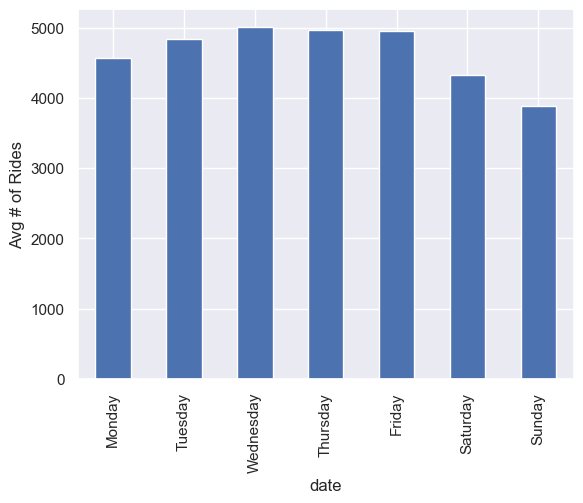

In [236]:
# Visualize weekly cycle
days = train.groupby(train.index.dayofweek).mean().plot(kind='bar')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']);
plt.ylabel('Avg # of Rides');

Weekly activity is not exactly sinusoidal, so let's proceed with modeling it as a categorical feature. We'll use one-hot encoding for the day of the week.

Training score: 0.7054489994404537
Validation score: 0.3626701646693512


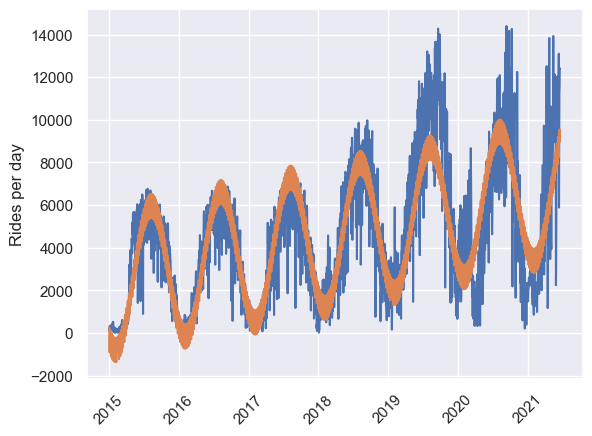

In [281]:
class DayofWeek(base.BaseEstimator, base.TransformerMixin):
    '''One-hot encode day of week as categorical feature'''
    
    def fit(self, X, y=None):
        return self
    
    def day_vector(self, day):
        v = np.zeros(7)
        v[day] = 1
        return v
    
    def transform(self, X):
        return np.stack([self.day_vector(d) for d in X.dayofweek])

union = FeatureUnion([('drift', QuadBackground()),
                      ('fourier_1yr', FourierComponents(365)),
                      ('dayofweek', DayofWeek())])
                      
model_drift_seasonality = Pipeline([('union', union),
                                ('regressor', Ridge())])

model_drift_seasonality.fit(train.index, train)

# Visualize results
plt.plot(train.index, train, 
         train.index, model_drift_seasonality.predict(train.index));
plt.xticks(rotation=45);
plt.ylabel('Rides per day');

# Metrics check
print(f'Training score: {model_drift_seasonality.score(train.index, train)}')
print(f'Validation score: {model_drift_seasonality.score(valid.index, valid)}')

### Modeling Noise
Next let's model the noise in the residuals of the drift + seasonality model. The goal is to find and model correlated noise which can be used to predict future noise.

In [240]:
# Compute residuals
train_noise = (train - model_drift_seasonality.predict(train.index)).squeeze()
valid_noise = (valid - model_drift_seasonality.predict(valid.index)).squeeze()

Let's plot autocorrelation. The solid and dashed lines represent 95% and 99% confidence levels, respectively, for the zero-correlation hypothesis. Note that autocorrelation is one at zero lag despite not being visible on the plot.

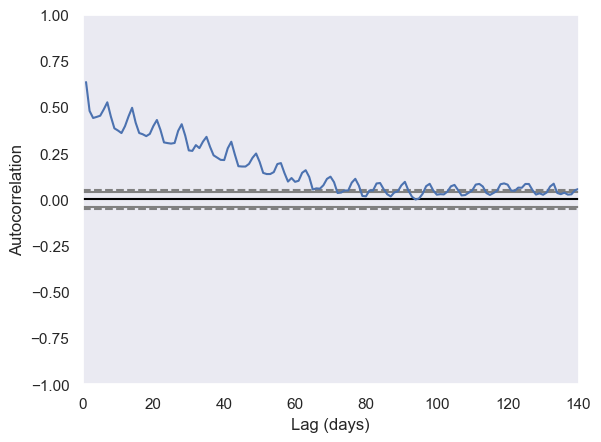

In [245]:
# Plot autocorrelation
autocorrelation_plot(train_noise)
plt.xlabel('Lag (days)')
plt.xlim([0, 140]);

Autocorrelation drops within the confidence interval at around 80 days. Thus we should only consider noise up to 80 days prior when predicting future noise.

In [246]:
class ResidualFeatures(base.BaseEstimator, base.TransformerMixin):
    """Generate features based on window statistics of past noise/residuals."""

    def __init__(self, window=80):
        self.window = window
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df = pd.DataFrame()
        df['residual'] = pd.Series(X, index=X.index)
        df['prior'] = df['residual'].shift(1)
        df['mean'] = df['residual'].rolling(window=self.window, min_periods=0).mean()
        df['diff'] = df['residual'].diff().rolling(window=self.window).mean()
        df = df.fillna(method='bfill')
        
        return df

How far into the future the model is able to forecast is also a parameter that must be set. Let's try generating a model that predicts ridership demand 5 days into the future.

In [253]:
from sklearn.metrics import r2_score

DAYS_INTO_FUTURE = 5

# Create and train residual model
noise_model = Pipeline([('residual_features', ResidualFeatures(window=80)), 
                        ('regressor', Ridge())])

noise_model.fit(train_noise.iloc[:-DAYS_INTO_FUTURE], 
                train_noise.shift(-DAYS_INTO_FUTURE).dropna())

# Evaluate noise model
noise_pred = noise_model.predict(valid_noise)
df_valid_noise = pd.Series(noise_pred, index=valid.index).to_frame(name='noise_pred')
df_valid_noise['target_noise'] = valid_noise.shift(-DAYS_INTO_FUTURE)
df_valid_noise = df_valid_noise.dropna()
print(f"Residual validation set R^2: {r2_score(df_valid_noise['target_noise'], df_valid_noise['noise_pred'])}")

Residual validation set R^2: 0.4078789566337042


In [278]:
class FullModel(base.BaseEstimator, base.RegressorMixin):
    """Complete model for drift, seasonlity, and noise"""
    
    def __init__(self, baseline, noise_model, steps=3):
        """Combine a baseline and residual model to predict any number of steps in the future."""
        self.baseline = baseline
        self.noise_model = noise_model
        self.steps = steps
        
    def fit(self, X, y):
        self.baseline.fit(X.index, y)
        resd = (y - self.baseline.predict(X.index))
        self.noise_model.fit(resd.iloc[:-self.steps], resd.shift(-self.steps).dropna())
                
        return self
    
    def predict(self, X):
        y_b = pd.Series(self.baseline.predict(X.index), index=X.index)
        resd = X - y_b
        resd_pred = pd.Series(self.noise_model.predict(resd), index=X.index)
        resd_pred = resd_pred.shift(self.steps)
        y_pred = y_b + resd_pred
        
        return y_pred
    
# Construct and train full model
full_model = FullModel(model_drift_seasonality, noise_model, steps=DAYS_INTO_FUTURE)
full_model.fit(train, train)
y_pred_train = full_model.predict(train)
print(f"Train R^2: {r2_score(train.iloc[DAYS_INTO_FUTURE:], y_pred_train.dropna())}")

# Make predictions
y_pred_valid = full_model.predict(valid)
print(f"Validation R^2: {r2_score(valid.iloc[DAYS_INTO_FUTURE:], y_pred_valid.dropna())}")

Train R^2: 0.7921952448097515
Validation R^2: 0.7139389921190384


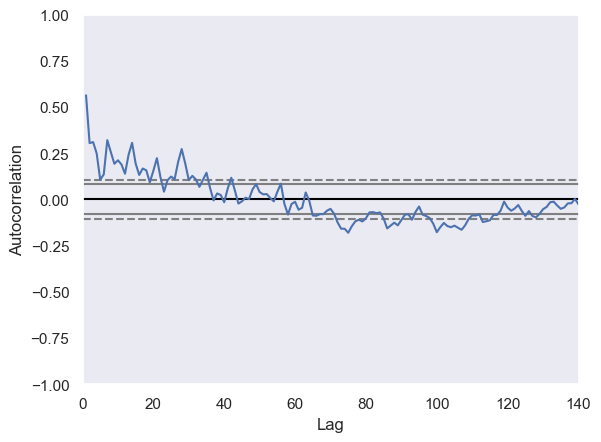

In [264]:
# Check autocorrelation plot again
resd = valid.iloc[DAYS_INTO_FUTURE:] -  y_pred_valid.dropna()
autocorrelation_plot(resd)
plt.xlim([0, 140]);

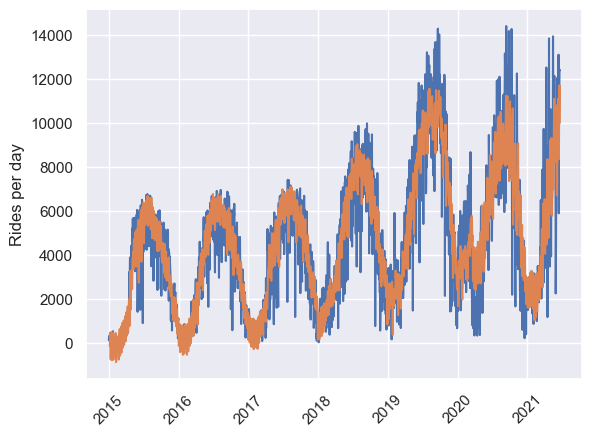

In [282]:
# Visualize results on training data
plt.plot(train.index, train, train.index, full_model.predict(train));
plt.xticks(rotation=45);
plt.ylabel('Rides per day');

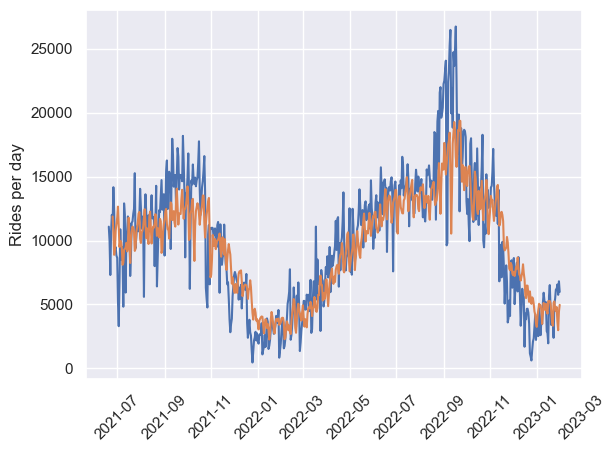

In [283]:
# Visualize results on validation data
plt.plot(valid.index, valid, valid.index, full_model.predict(valid));
plt.xticks(rotation=45);
plt.ylabel('Rides per day');